# House Amenity and Rental Price --- Data Discovery of Boston Airbnb

## CRISP-DM Process --- Overall Structure

**Business Understanding**

Boston Airbnb listing dataset is available, our interest is to get a better knowledge about basic attribute of factors influencing rental prices, like location and amenity, and how they influence the price.
Three questions are raised around the interest:
1. What is the relationship between location and price?  
2. What are the most popular amenities?  
3. What are the top amenities that influence the price?  

**Data Understanding**

Boston Airbnb listing has 3585 rows, 95 columns representing listing attributes.

**Prepare Data**

The preparation includes data cleaning, filling missing value, encoding categorical values and feature scaling.

**Data Modeling**

We model the regression of rental price with Random Forest Model. GridSearchCV is applied to find suitable parameters.  

**Evaluate the Results**

Results are summarized in the Medium post. Visit. 

## Libraries

In [236]:
# Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
# Datetime processing
from datetime import date
from datetime import datetime
# Sklearn ML Modules
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder,OneHotEncoder,StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import sklearn.metrics as mtr
# Dismiss the warnings
import warnings
warnings.filterwarnings('ignore')

## Dataset Observation ##

In [190]:
# Import the dataset
listing=pd.read_csv('listings.csv')

In [191]:
# Observe the data structure
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [192]:
# Describe the dataset
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

In [193]:
# Observe missing data
null_ratio = listing.isnull().sum()/listing.shape[0]

 ## Q1. Location and Price

In [194]:
# Convert Price to numerics.

listing['price']=listing['price'].str.replace('[$,]','',regex=True).astype(float)

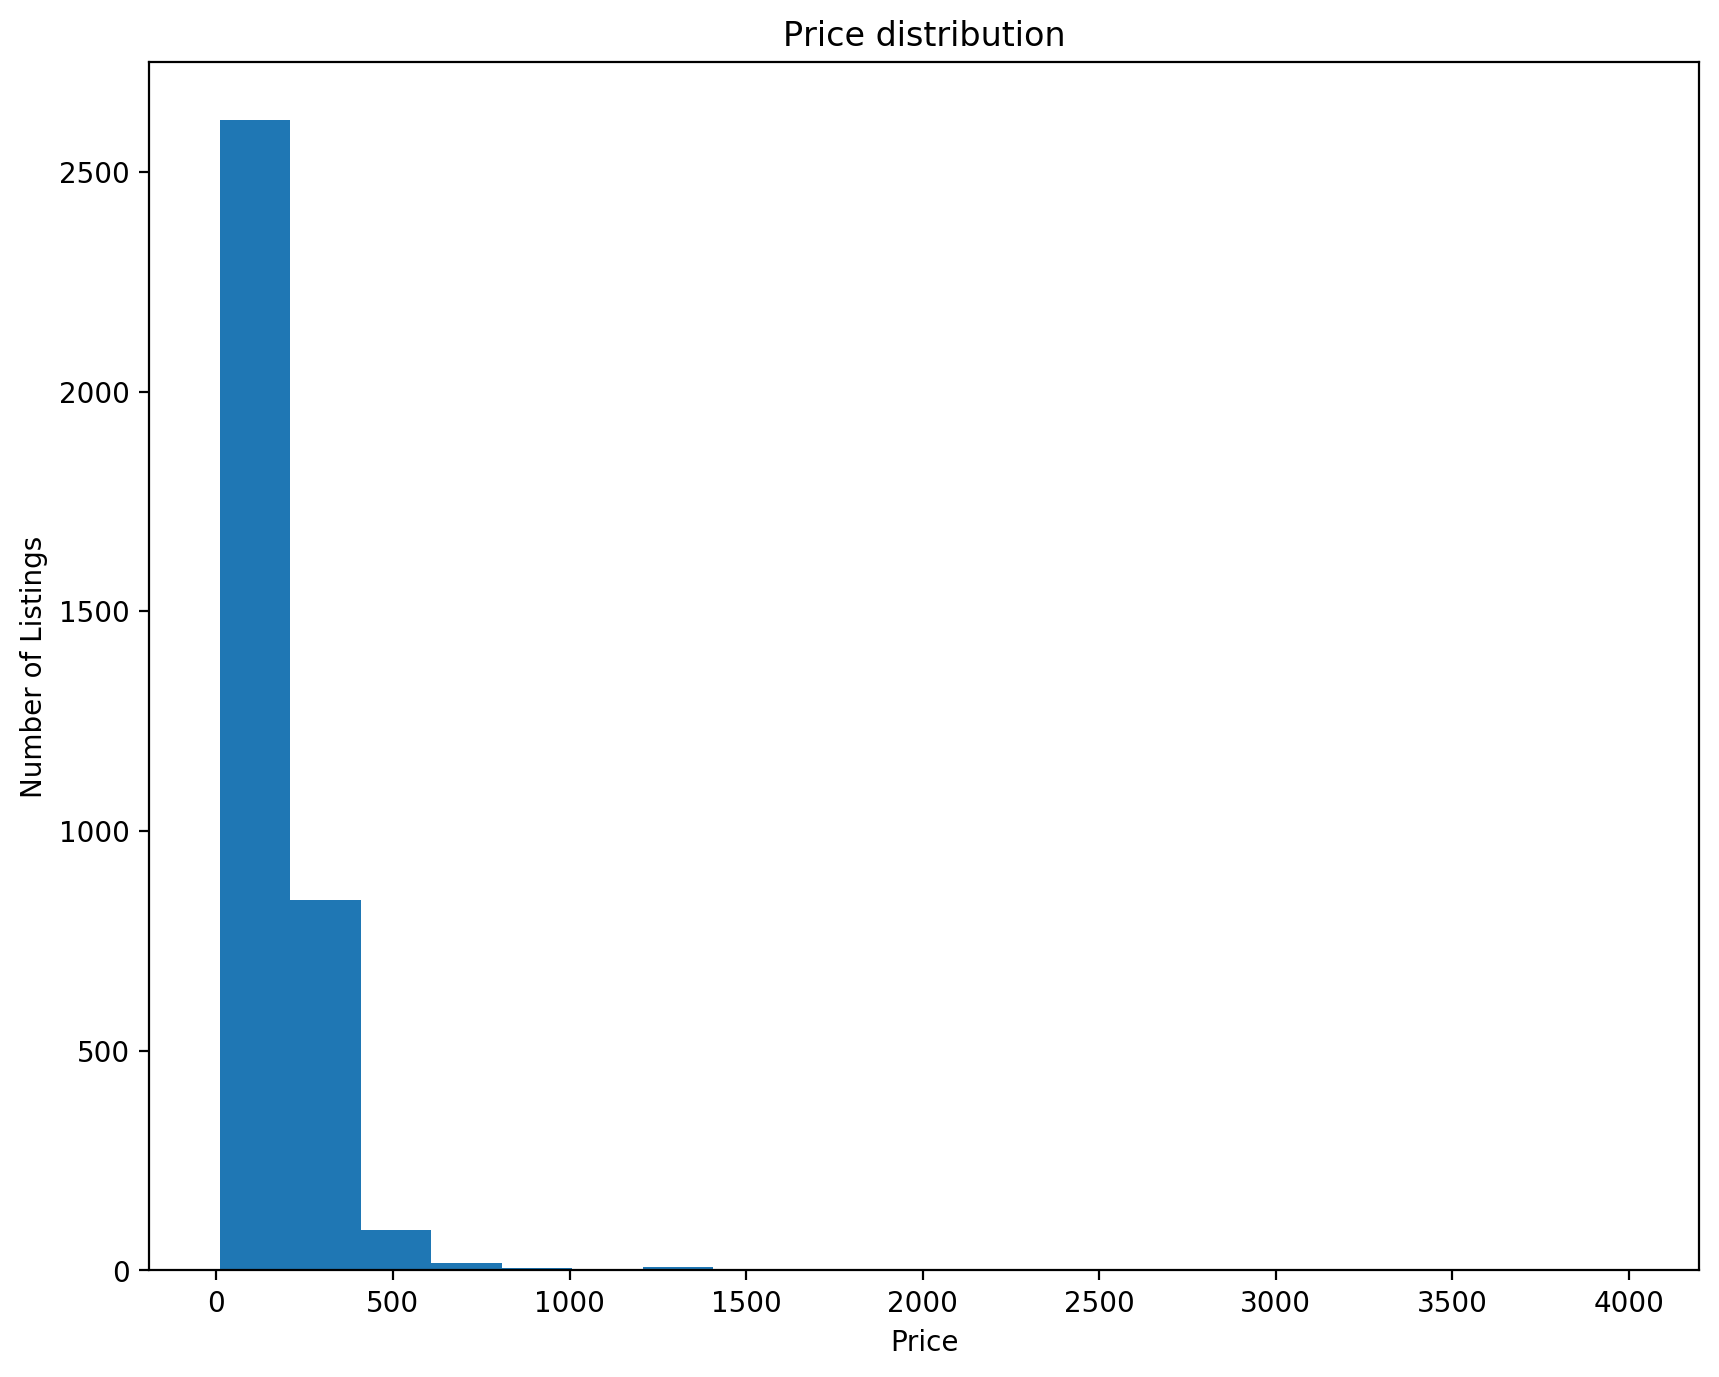

In [195]:
# Plot the price distribution
plt.figure(figsize=(10, 8),dpi=200)
plt.hist(listing.price, bins=20)
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.show()

# Drop large price rows and some other useless columns
listing = listing.drop(listing[listing.price > 1000].index, axis=0)

In [196]:
# Plot the listing locations

location = listing[['city', 'latitude', 'longitude', 'price']]

px.set_mapbox_access_token('pk.eyJ1IjoiYW5rYWF5YSIsImEiOiJjazU3cGYyNWMwNmdqM2ZrZXVqMTVxdWE2In0.39rWvY_KN7Rakj4M0GeQZQ')
fig = px.scatter_mapbox(location[location['price']<=750], lat="latitude", lon="longitude", color="price",
                        color_continuous_scale=px.colors.cyclical.IceFire, zoom=10)
fig.show()

In [197]:
# Average price of cities

city_price = location.groupby(
    'city')['price'].mean().sort_values(ascending=False)
top10 = pd.DataFrame(
    {'city': city_price[:10].index, 'average': city_price[:10].values})
top10.head(n=10).style.format(
    {'average': "${:.0f}"}).background_gradient(cmap='Blues')

,city,average
0,"South End, Boston",$450
1,Charlestown,$263
2,Boston (Charlestown),$200
3,"Roslindale, Boston",$200
4,Cambridge,$199
5,Jamaica Plain,$178
6,Boston,$172
7,ALLSTON,$165
8,Jamaica Plain (Boston),$150
9,Brookline,$136


## Preprocessing, Drop

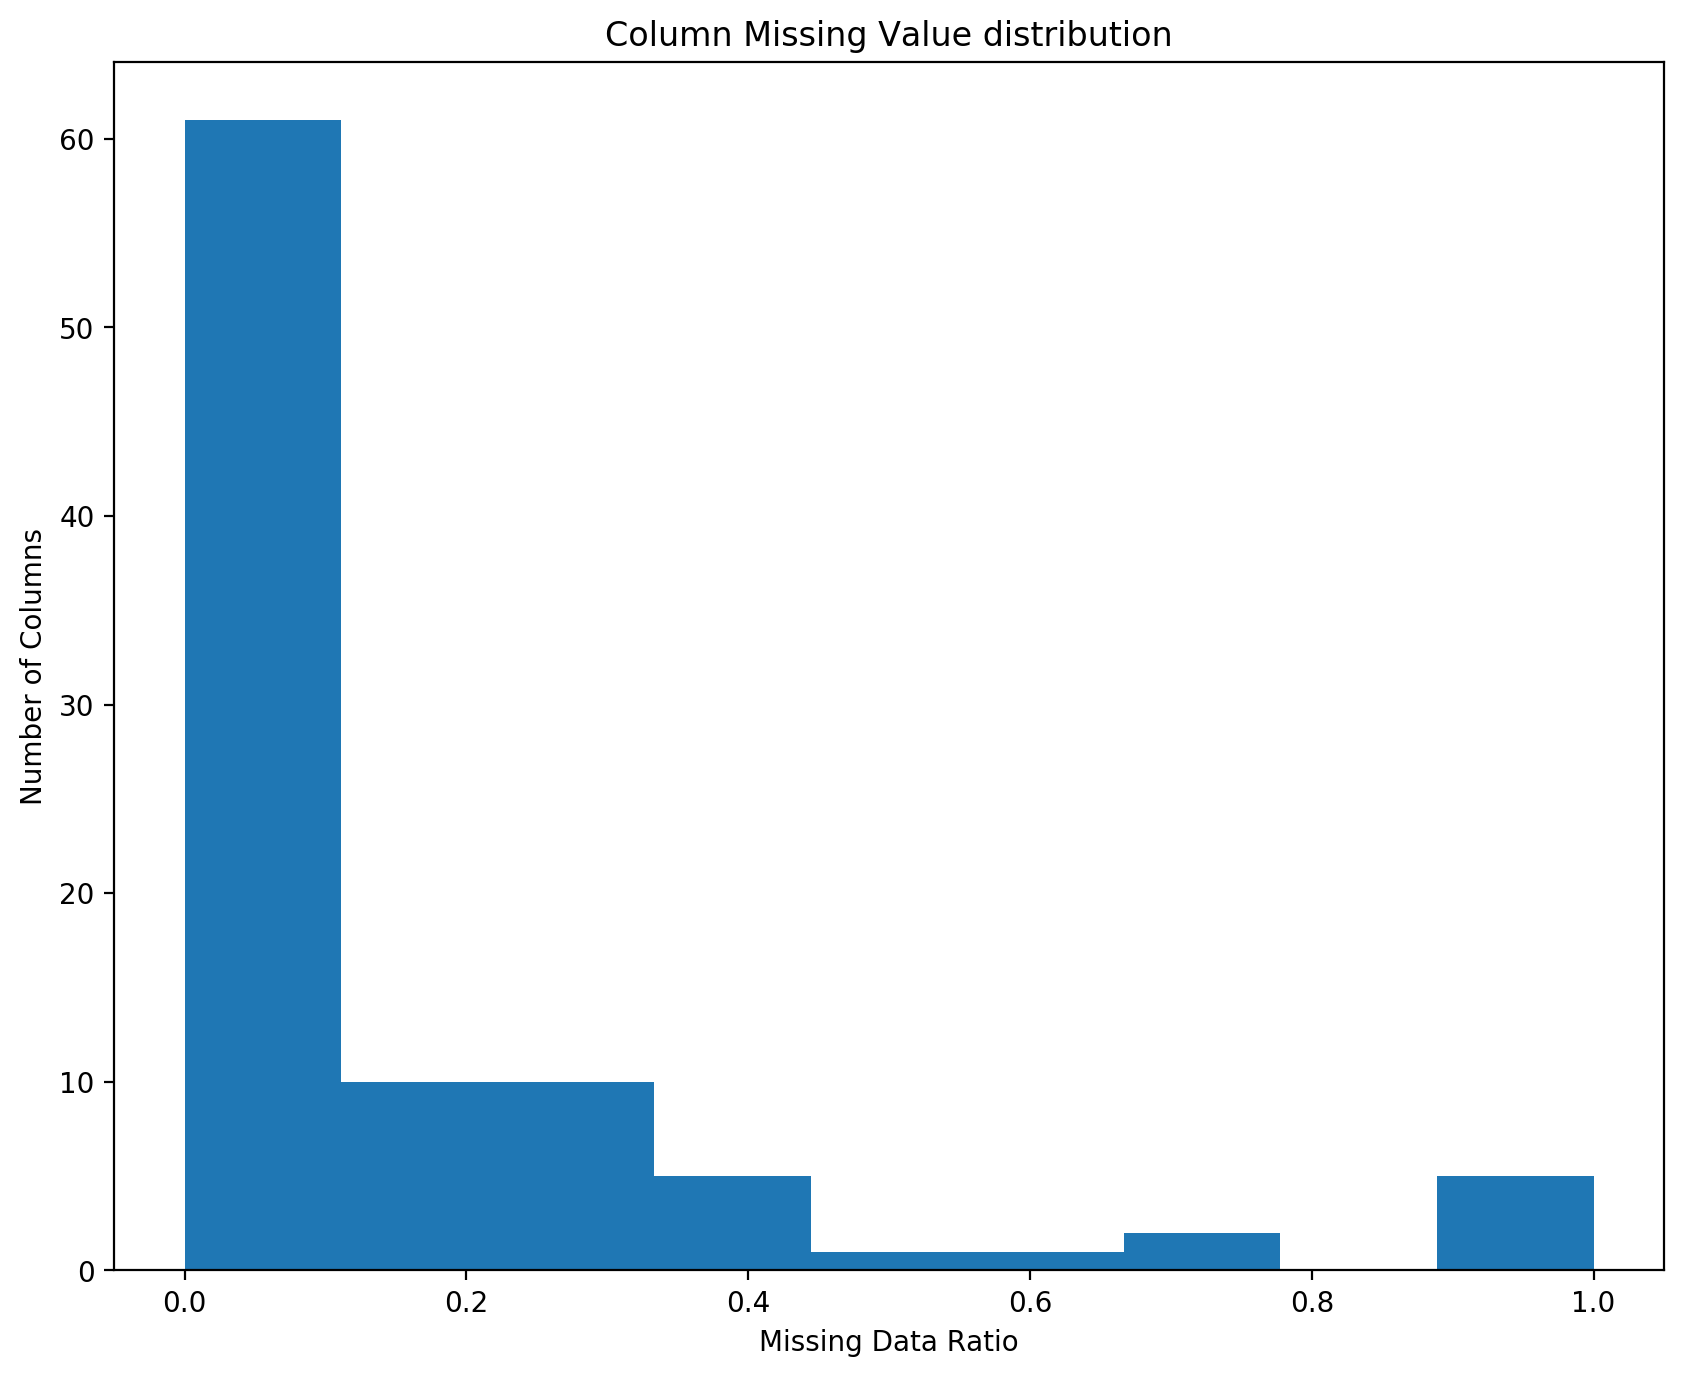

In [198]:
# Plot the Over-half columns
plt.figure(figsize=(10, 8),dpi=200)
plt.hist(null_ratio, bins=np.linspace(0, 1, 10))
plt.title('Column Missing Value distribution')
plt.xlabel('Missing Data Ratio')
plt.ylabel('Number of Columns')
plt.show()

In [199]:
# Observe and Remove columns with over half missing
over_50 = null_ratio[null_ratio > 0.5].sort_values()
print(over_50)
listing = listing.drop(over_50.index, axis=1)

notes                           0.550907
security_deposit                0.625662
weekly_price                    0.751185
monthly_price                   0.752301
square_feet                     0.984379
neighbourhood_group_cleansed    1.000000
has_availability                1.000000
license                         1.000000
jurisdiction_names              1.000000
dtype: float64


In [200]:
# Drop unused columns
unused = ['space', 'neighborhood_overview', 'transit', 'access', 'interaction', 'house_rules', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'description', 'experiences_offered', 'picture_url', 'host_url', 'host_name', 'host_thumbnail_url', 'host_about',
          'host_neighbourhood', 'host_response_time', 'host_acceptance_rate','thumbnail_url','medium_url', 'xl_picture_url','host_picture_url', 'host_location', 'street', 'city', 'state', 'smart_location', 'country_code', 'country', 'first_review', 'last_review', 'id', 'host_verifications', 'host_id', 'neighbourhood', 'calendar_last_scraped', 'market']
listing = listing.drop(unused, axis=1)

## Q2. Amenities

In [201]:
# Amenities as 0-1 categorical columns
amenities = listing['amenities'].apply(lambda x: [amenity.replace(
    '"', "").replace("{", "").replace("}", "") for amenity in x.split(",")])

In [202]:
amenities

0       [TV, Wireless Internet, Kitchen, Free Parking ...
1       [TV, Internet, Wireless Internet, Air Conditio...
2       [TV, Cable TV, Wireless Internet, Air Conditio...
3       [TV, Internet, Wireless Internet, Air Conditio...
4       [Internet, Wireless Internet, Air Conditioning...
                              ...                        
3580    [Internet, Wireless Internet, Air Conditioning...
3581    [TV, Internet, Wireless Internet, Air Conditio...
3582    [translation missing: en.hosting_amenity_49, t...
3583    [Kitchen, Gym, Family/Kid Friendly, Washer, Dr...
3584    [Wireless Internet, Kitchen, Essentials, trans...
Name: amenities, Length: 3575, dtype: object

In [203]:
mlb = MultiLabelBinarizer()
amenities_label = pd.DataFrame(mlb.fit_transform(
    amenities), columns=mlb.classes_, index=amenities.index)

# Sum the amenities labels
amenities_count=amenities_label.sum().sort_values(ascending=False)
print('There are {0} kinds of amenities'.format(len(amenities_label.columns)))

There are 46 kinds of amenities


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

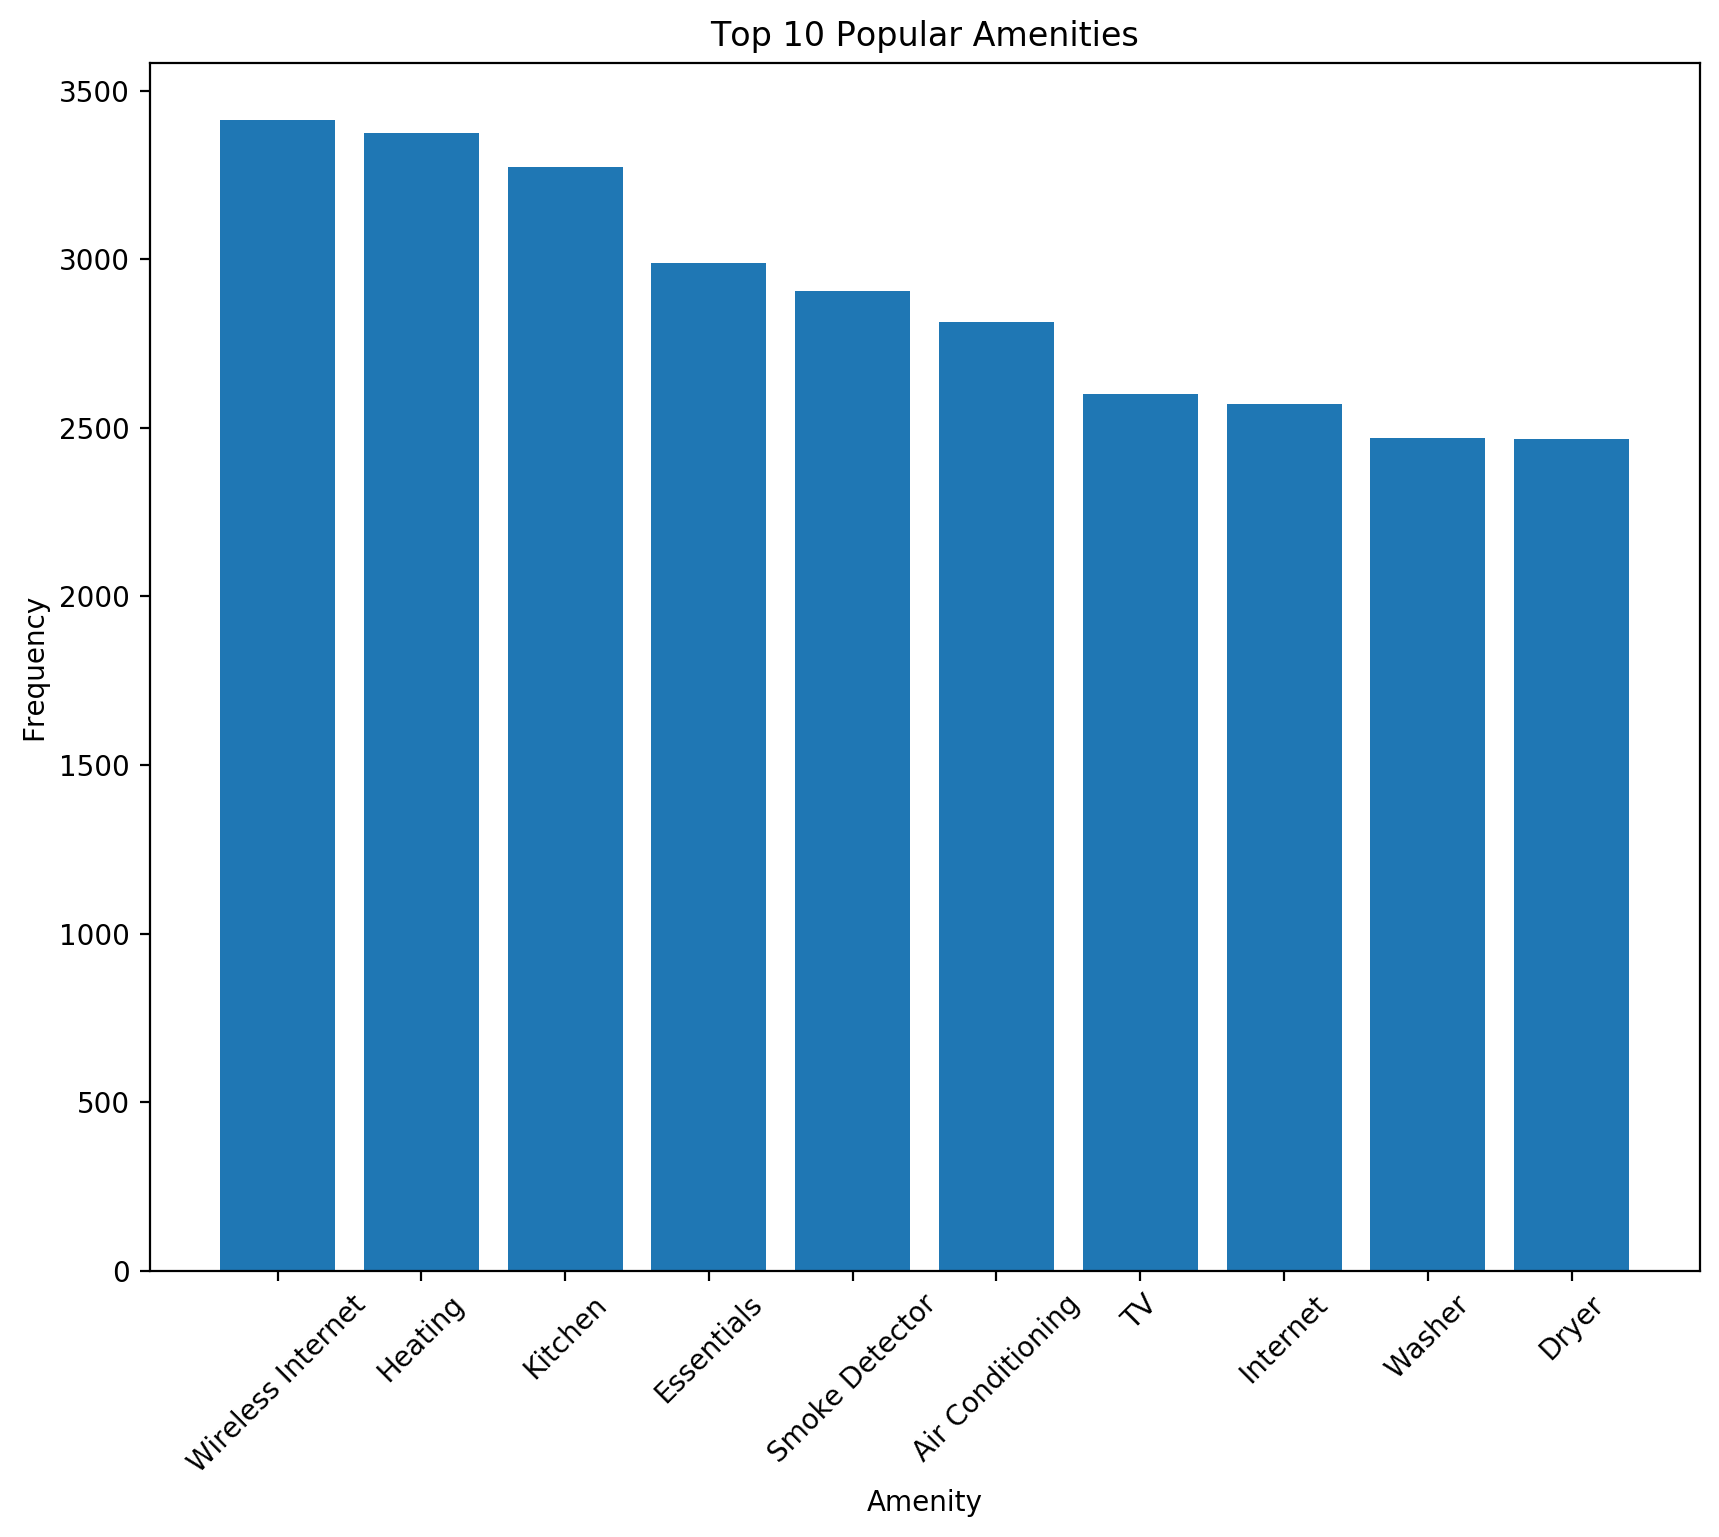

In [204]:
plt.figure(figsize=(10,8),dpi=200)
plt.bar(amenities_count[:10].index,amenities_count[:10].values)
plt.title('Top 10 Popular Amenities')
plt.xlabel('Amenity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

## Preprocessing

In [205]:
# Compute Host Days
listing['host_since'] = listing['host_since'].apply(
    lambda x: (datetime.now() - datetime.strptime(x, '%Y-%m-%d')).days)

# Converting str-format numbers into numerical values
processing_number_column = [
    'cleaning_fee', 'extra_people', 'host_response_rate']
for column in processing_number_column:
    listing[column] = listing[column].replace(r'[$,%]', '', regex = True).astype(float)

In [206]:
# Fill missing data, median for rooms
fill_median=['bathrooms', 'beds', 'bedrooms']
for room in fill_median:
    listing[room]=listing[room].fillna(listing.groupby("bedrooms")[
                             room].median)

# Fill mean and zero to specific column
fill_mean=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value', 'reviews_per_month', 'host_response_rate']
fill_zero= ['cleaning_fee']
imputer_mean = SimpleImputer(strategy = 'mean')
imputer_zero = SimpleImputer(strategy = 'constant', fill_value = 0)
ct= ColumnTransformer([('imputer_mean', imputer_mean, fill_mean),
                     ('imputer_zero', imputer_zero, fill_zero)])
to_fill=listing[fill_mean+fill_zero]
filled = ct.fit_transform(to_fill)
filled=pd.DataFrame(data=filled,columns=fill_mean+fill_zero)

In [207]:
listing=pd.concat([listing.drop(fill_mean+fill_zero,axis=1),filled],axis=1)

In [208]:
# Fill zipcode
listing['zipcode'] = listing['zipcode'].fillna(listing.groupby('neighbourhood_cleansed')['zipcode'].apply(lambda x: x.fillna(x.value_counts().index[0])))

In [209]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 3584
Data columns (total 46 columns):
host_since                          3575 non-null float64
host_is_superhost                   3575 non-null object
host_listings_count                 3575 non-null float64
host_total_listings_count           3575 non-null float64
host_has_profile_pic                3575 non-null object
host_identity_verified              3575 non-null object
neighbourhood_cleansed              3575 non-null object
zipcode                             3575 non-null object
latitude                            3575 non-null float64
longitude                           3575 non-null float64
is_location_exact                   3575 non-null object
property_type                       3572 non-null object
room_type                           3575 non-null object
accommodates                        3575 non-null float64
bathrooms                           3575 non-null object
bedrooms                        

In [210]:
amenities_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3575 entries, 0 to 3584
Data columns (total 46 columns):
                                              3575 non-null int32
24-Hour Check-in                              3575 non-null int32
Air Conditioning                              3575 non-null int32
Breakfast                                     3575 non-null int32
Buzzer/Wireless Intercom                      3575 non-null int32
Cable TV                                      3575 non-null int32
Carbon Monoxide Detector                      3575 non-null int32
Cat(s)                                        3575 non-null int32
Dog(s)                                        3575 non-null int32
Doorman                                       3575 non-null int32
Dryer                                         3575 non-null int32
Elevator in Building                          3575 non-null int32
Essentials                                    3575 non-null int32
Family/Kid Friendly                

In [211]:
# Bind amenities 0-1 categorical columns
listing=pd.concat([listing, amenities_label], axis=1, sort=False).drop(
    'amenities', axis = 1)

listing.dropna(inplace=True)

In [212]:
# One-hot encoding the whole dataframe
listing=pd.get_dummies(listing)
Price=listing['price']
listing=listing.drop('price', axis = 1)

# Use MinMax to process some of the numerical data
ss=StandardScaler()
scale_list=['host_since', 'latitude', 'longitude', 'review_scores_rating']
listing[scale_list]=ss.fit_transform(listing[scale_list])

listing.dropna(inplace=True)

In [215]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3562 entries, 0 to 3574
Columns: 249 entries, host_since to require_guest_phone_verification_t
dtypes: float64(72), uint8(177)
memory usage: 2.7 MB


## Q3. Important Features of Price

In [243]:
# Grid Search Lasso Model
param_grid = {'alpha': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
las=Lasso()
grid_search=GridSearchCV(las,param_grid,cv=5,scoring='r2',return_train_score=True)
grid_search.fit(listing,Price)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [246]:
# Best Parameter
print(grid_search.best_params_)
print(grid_search.score(listing,Price))

{'alpha': 0.1}
0.6327464460543575


In [247]:
# Make alpha=0.1 Lasso Model
las1=Lasso(alpha=0.1)
las1.fit(listing,Price)
las1.coef_

array([-0.00000000e+00, -1.43597620e-01, -1.10095203e-16,  1.05483937e+01,
        1.05990886e+01,  8.20879660e+00,  4.90432772e+00, -1.09361763e-01,
        1.23677152e-01, -3.76441469e-08,  4.24873968e-01,  4.38401742e-01,
        6.91637258e-02, -1.19129996e-03, -1.82071222e-01,  4.82847708e-01,
        7.50225780e-01,  4.65383774e-01,  1.19914131e+00, -0.00000000e+00,
       -1.07674118e+00, -6.47663344e-01,  0.00000000e+00, -1.76678512e-01,
        3.63726741e-02,  2.69282051e-02,  6.59796309e-01, -8.05572065e+00,
        1.27427307e+01,  7.19530429e+00,  2.31941211e+00,  6.74610986e+00,
        4.18507445e+00, -6.20058458e+00,  4.34976989e+00,  1.43475061e+01,
        2.98682046e+00,  1.06520282e+01, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  3.81549489e+00, -8.34395297e+00, -0.00000000e+00,
        2.12654814e+00,  2.69676126e+00, -1.21940410e+01, -0.00000000e+00,
        0.00000000e+00,  2.06411743e+01, -3.83096972e-01, -9.58745181e-01,
       -1.55100848e+01,  

In [249]:
# Select features by Lasso
model=SelectFromModel(las1,prefit=True)
X_new=model.transform(listing)
print(X_new.shape)
model.get_support()

(3562, 131)


array([False,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True, False,  True,  True,  True, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False,

In [252]:
# Assign X,y
X=listing.iloc[:,model.get_support()]
y=Price

In [253]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# GridSearch Parameters
param_grid = {'n_estimators': [100, 250, 400],
              'max_leaf_nodes':range(100,1001,100)
              }

In [254]:
# Set Random Forest GridSearchCV Engine
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_leaf_nodes': range(100, 1001

In [256]:
# Random Forest Model Performance
print(grid_search.best_params_)
print(grid_search.score(X_train,y_train))
print(mtr.r2_score(y_test,grid_search.predict(X_test)))

{'max_leaf_nodes': 900, 'n_estimators': 400}
0.9516693179399547
0.5348360624946407


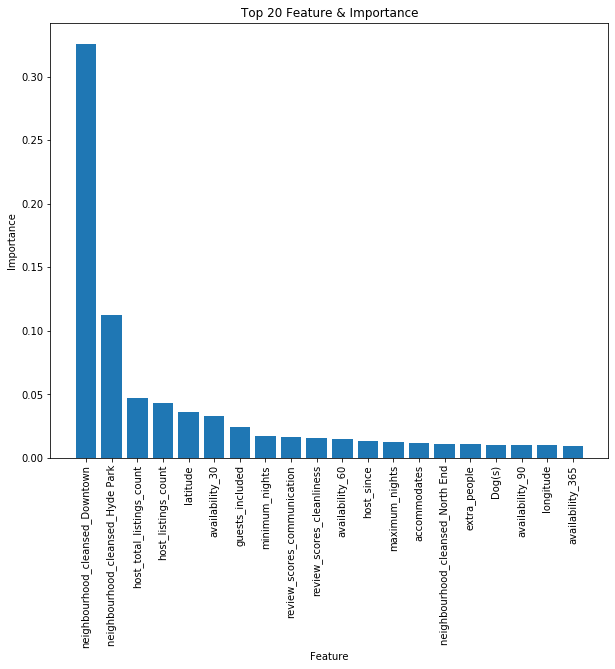

In [255]:
# Collect importance data
feature_importance = grid_search.best_estimator_.feature_importances_
feature = sorted(zip(feature_importance, listing.columns), reverse=True)
attribute = []
coefficient = []
for i in range(20):
    attribute.append(feature[i][1])
    coefficient.append(feature[i][0])

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.bar(attribute[:20], height=coefficient[:20])
plt.title('Top 20 Feature & Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()